# Gradients of models:

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amssymb}')

In [4]:
def softmax(x, axis=None):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)

In [5]:
def softplus(x):
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

In [6]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

In [7]:
def entropy(x, axis=None, from_logits=False):
    if from_logits:
        x = softmax(x, axis=axis)
        
    H = -np.sum(x*np.log(x), axis=axis, keepdims=True)
    return H
    

In [8]:
def onehot_encode(X, n_classes=None):
    N = X.shape[0]

    if n_classes is None:
        n_classes = X.max()+1

    onehot = np.zeros((N, n_classes))
    onehot[np.arange(N), X] = 1.

    return onehot

### Load logits:

In [9]:
CIFAR10_PATH = '../../data/CIFAR10'
MODEL_PATH = '../../trained_models/CIFAR10/resnet50'

In [10]:
X_train = np.load(os.path.join(CIFAR10_PATH, 'train_imas.npy'))
y_train = np.load(os.path.join(CIFAR10_PATH, 'train_labels.npy'))

X_val = np.load(os.path.join(CIFAR10_PATH, 'val_imas.npy'))
y_val = np.load(os.path.join(CIFAR10_PATH, 'val_labels.npy'))

X_test = np.load(os.path.join(CIFAR10_PATH, 'test_imas.npy'))
y_test = np.load(os.path.join(CIFAR10_PATH, 'test_labels.npy'))

In [11]:
Z_train = np.load(os.path.join(MODEL_PATH, 'train_logits.npy'))
Z_val = np.load(os.path.join(MODEL_PATH, 'val_logits.npy'))
Z_test = np.load(os.path.join(MODEL_PATH, 'test_logits.npy'))

### Temp-Scaling

In [12]:
t = 2.2

In [13]:
def grad(t, logits, onehot_target):
    preds = softmax(logits/t, axis=1)
    grad = -(1/t**2)*np.sum(logits*(preds-onehot_target))
    return grad

In [14]:
comp_grad = grad(t, Z_val, onehot_encode(y_val))

In [15]:
eps = 1e-5
def estimate_grad(t, logits, onehot_target):
    t += eps
    preds_pe = softmax(logits/t, axis=1)
    loss_pe = -np.sum(np.log(np.sum(preds_pe*onehot_target, axis=1)))
    
    t -= 2*eps
    preds_me = softmax(logits/t, axis=1)
    loss_me = -np.sum(np.log(np.sum(preds_me*onehot_target, axis=1)))
    
    grad = (loss_pe-loss_me)/(2*eps)
    
    return grad

In [16]:
est_grad = estimate_grad(t, Z_val, onehot_encode(y_val))

In [17]:
print('Analytic gradient is: {}\n \testimated one is: {}'.format(comp_grad, est_grad))

Analytic gradient is: -315.90394595097854
 	estimated one is: -315.61149573917646


In [18]:
ts = np.linspace(0.8, 5, 200)

grads = np.zeros(200)
est_grads = np.zeros(200)
losses = np.zeros(200)

for i, t in enumerate(ts):
    grads[i] = grad(t, Z_val, onehot_encode(y_val))
    est_grads[i] = estimate_grad(t, Z_val, onehot_encode(y_val))
    
    preds = softmax(Z_val/t, axis=1)
    losses[i] = -np.sum(np.log(np.sum(preds*onehot_encode(y_val), axis=1)))

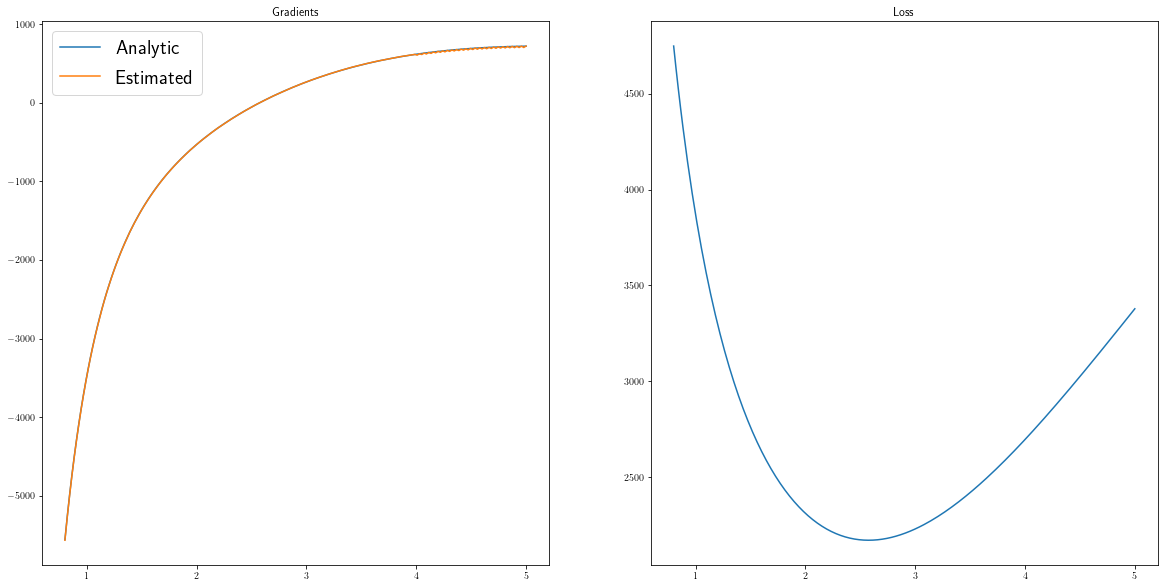

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(ts, grads, label='Analytic')
ax[0].plot(ts, est_grads, label='Estimated')
ax[0].legend(fontsize=20)
ax[0].set_title('Gradients')


ax[1].plot(ts, losses)
ax[1].set_title('Loss')

plt.show()

### Soft-plus based temperature

In [20]:
def grad(x, logits, onehot_target):
    t = softplus(x)
    preds = softmax(logits/t, axis=1)
    grad = -(1/t**2)*np.sum(logits*(preds-onehot_target))*sigmoid(x)
    return grad

In [21]:
eps = 1e-5
def estimate_grad(x, logits, onehot_target):
    x += eps
    t = softplus(x)
    preds_pe = softmax(logits/t, axis=1)
    loss_pe = -np.sum(np.log(np.sum(preds_pe*onehot_target, axis=1)))
    
    x -= 2*eps
    t = softplus(x)
    preds_me = softmax(logits/t, axis=1)
    loss_me = -np.sum(np.log(np.sum(preds_me*onehot_target, axis=1)))
    
    grad = (loss_pe-loss_me)/(2*eps)
    
    return grad

In [22]:
xs = np.linspace(-2, 5, 200)

grads = np.zeros(200)
est_grads = np.zeros(200)
losses = np.zeros(200)

for i, x in enumerate(xs):
    grads[i] = grad(x, Z_val, onehot_encode(y_val))
    est_grads[i] = estimate_grad(x, Z_val, onehot_encode(y_val))
    
    t = softplus(x)
    preds = softmax(Z_val/t, axis=1)
    losses[i] = -np.sum(np.log(np.sum(preds*onehot_encode(y_val), axis=1)))

<ipython-input-21-ad527a70bed8>:6: RuntimeWarning: divide by zero encountered in log
  loss_pe = -np.sum(np.log(np.sum(preds_pe*onehot_target, axis=1)))
<ipython-input-21-ad527a70bed8>:11: RuntimeWarning: divide by zero encountered in log
  loss_me = -np.sum(np.log(np.sum(preds_me*onehot_target, axis=1)))
<ipython-input-21-ad527a70bed8>:13: RuntimeWarning: invalid value encountered in double_scalars
  grad = (loss_pe-loss_me)/(2*eps)
<ipython-input-22-4cd3889140e2>:13: RuntimeWarning: divide by zero encountered in log
  losses[i] = -np.sum(np.log(np.sum(preds*onehot_encode(y_val), axis=1)))


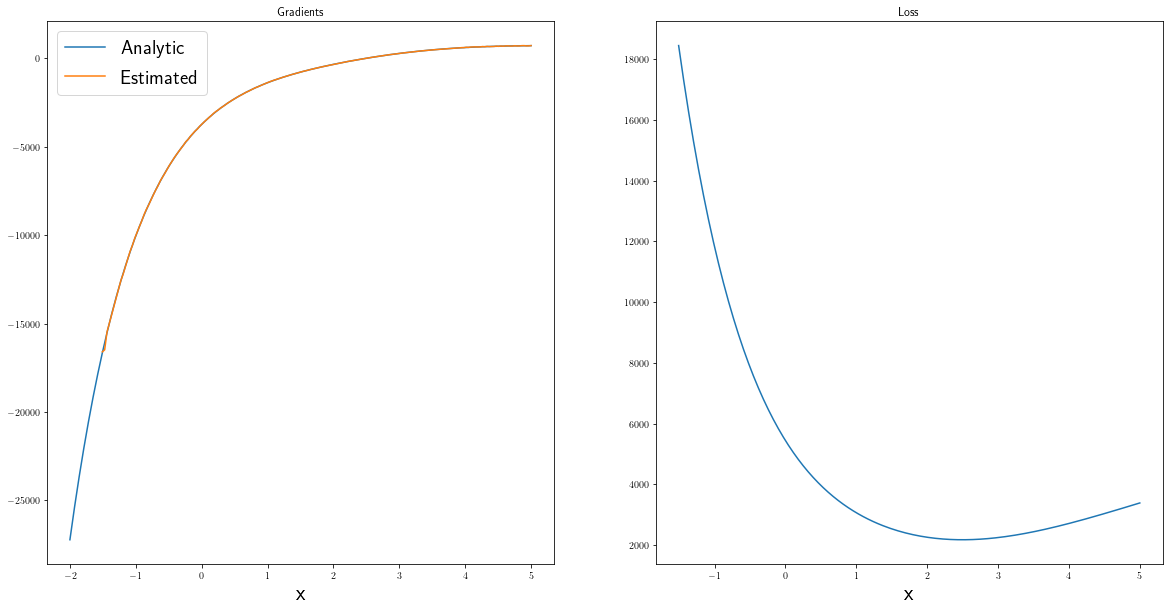

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(xs, grads, label='Analytic')
ax[0].plot(xs, est_grads, label='Estimated')
ax[0].legend(fontsize=20)
ax[0].set_title('Gradients')
ax[0].set_xlabel('x', fontsize=22)


ax[1].plot(xs, losses)
ax[1].set_title('Loss')
ax[1].set_xlabel('x', fontsize=22)

plt.show()

### Entropy based (HTS)

In [24]:
def grad(w, b, lhs, logits, onehot_target):
    x = w*lhs + b
    t = softplus(x)
    preds = softmax(logits/t, axis=1)
    
    grad_w = np.sum(np.sum(-(1/t**2)*logits*(preds-onehot_target), axis=1, keepdims=True) * sigmoid(x)*lhs)
    grad_b = np.sum(np.sum(-(1/t**2)*logits*(preds-onehot_target), axis=1, keepdims=True) * sigmoid(x))
    
    return grad_w, grad_b

In [25]:
eps = 1e-5
def estimate_grad_w(w, b, lhs, logits, onehot_target):
    w += eps
    t = softplus(w*lhs + b)
    preds_pe = softmax(logits/t, axis=1)
    loss_pe = -np.sum(np.log(np.sum(preds_pe*onehot_target, axis=1)))
    
    
    w -= 2*eps
    t = softplus(w*lhs + b)
    preds_me = softmax(logits/t, axis=1)
    loss_me = -np.sum(np.log(np.sum(preds_me*onehot_target, axis=1)))
    
    grad = (loss_pe-loss_me)/(2*eps)
    
    return grad

In [26]:
eps = 1e-5
def estimate_grad_b(w, b, lhs, logits, onehot_target):
    b += eps
    t = softplus(w*lhs + b)
    preds_pe = softmax(logits/t, axis=1)
    loss_pe = -np.sum(np.log(np.sum(preds_pe*onehot_target, axis=1)))
    
    
    b -= 2*eps
    t = softplus(w*lhs + b)
    preds_me = softmax(logits/t, axis=1)
    loss_me = -np.sum(np.log(np.sum(preds_me*onehot_target, axis=1)))
    
    grad = (loss_pe-loss_me)/(2*eps)
    
    return grad

In [27]:
ws = np.linspace(-0.2, 0.2, 200)
b = 2.0


grads = np.zeros(200)
est_grads = np.zeros(200)
losses = np.zeros(200)

hs = entropy(Z_val, axis=1, from_logits=True)
hs /= np.log(Z_val.shape[1])
lhs = np.log(hs)

for i, w in enumerate(ws):
    grads[i], _ = grad(w, b, lhs, Z_val, onehot_encode(y_val))
    est_grads[i] = estimate_grad_w(w, b, lhs, Z_val, onehot_encode(y_val))

    t = softplus(w*lhs + b)
    preds = softmax(Z_val/t, axis=1)
    losses[i] = -np.sum(np.log(np.sum(preds*onehot_encode(y_val), axis=1)))

In [28]:
w = -0.05
bs = np.linspace(0, 3, 200)


grads_b = np.zeros(200)
est_grads_b = np.zeros(200)
losses_b = np.zeros(200)

hs = entropy(Z_val, axis=1, from_logits=True)
hs /= np.log(Z_val.shape[1])
lhs = np.log(hs)

for i, b in enumerate(bs):
    _, grads_b[i] = grad(w, b, lhs, Z_val, onehot_encode(y_val))
    est_grads_b[i] = estimate_grad_b(w, b, lhs, Z_val, onehot_encode(y_val))

    t = softplus(w*lhs + b)
    preds = softmax(Z_val/t, axis=1)
    losses_b[i] = -np.sum(np.log(np.sum(preds*onehot_encode(y_val), axis=1)))

In [29]:
grad(w, b, lhs, Z_val, onehot_encode(y_val))

(-3629.337273466017, 428.9749223898204)

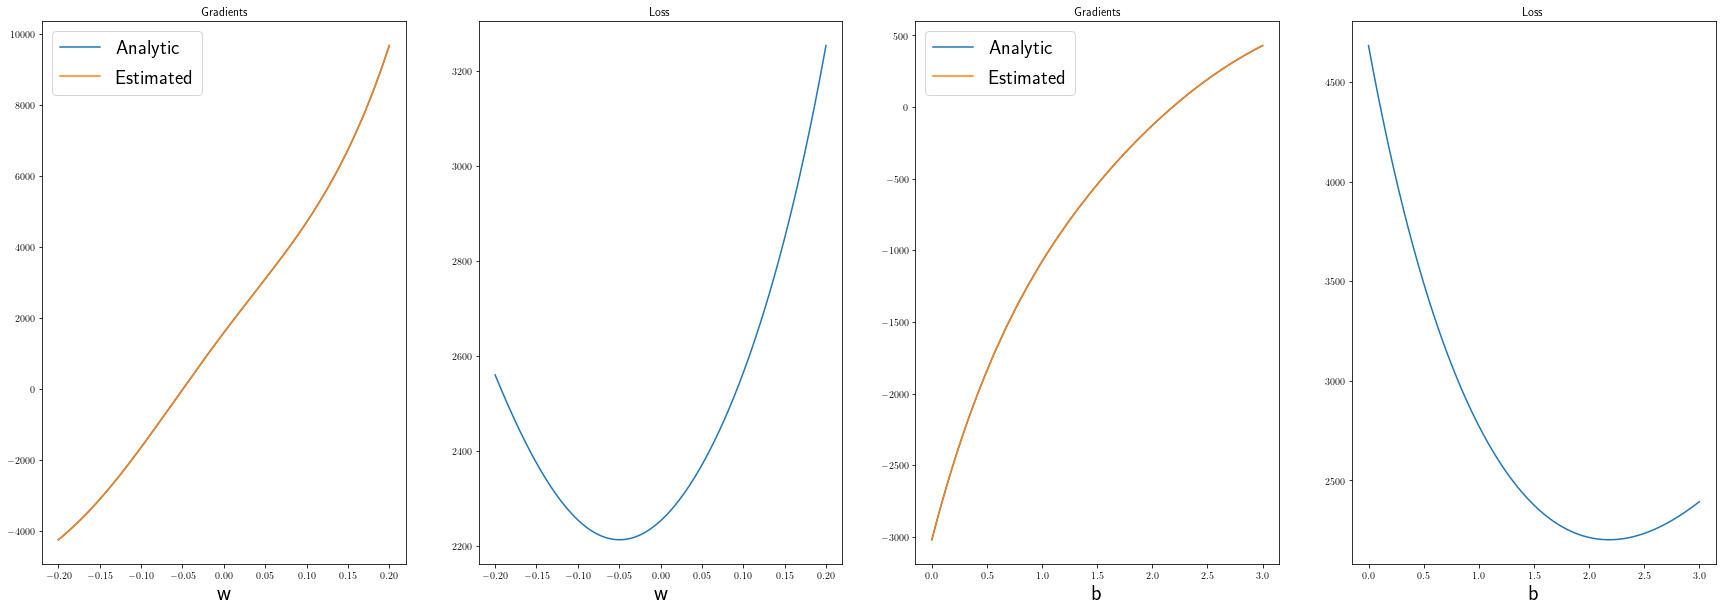

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(30, 10))

ax[0].plot(ws, grads, label='Analytic')
ax[0].plot(ws, est_grads, label='Estimated')
ax[0].legend(fontsize=20)
ax[0].set_title('Gradients')
ax[0].set_xlabel('w', fontsize=22)


ax[1].plot(ws, losses)
ax[1].set_title('Loss')
ax[1].set_xlabel('w', fontsize=22)


ax[2].plot(bs, grads_b, label='Analytic')
ax[2].plot(bs, est_grads_b, label='Estimated')
ax[2].legend(fontsize=20)
ax[2].set_title('Gradients')
ax[2].set_xlabel('b', fontsize=22)


ax[3].plot(bs, losses_b)
ax[3].set_title('Loss')
ax[3].set_xlabel('b', fontsize=22)

plt.show()

### Linear combination (LTS)

In [55]:
def grad(w, b, logits, onehot_target):
    x = (logits @ w + b).reshape([-1, 1])
    t = softplus(x)
    preds = softmax(logits/t, axis=1)
    
    grad_w = np.sum(np.sum(-(1/t**2)*logits*(preds-onehot_target), axis=1, keepdims=True) * sigmoid(x)*logits, axis=0)
    grad_b = np.sum(np.sum(-(1/t**2)*logits*(preds-onehot_target), axis=1, keepdims=True) * sigmoid(x))
    
    return grad_w, grad_b

In [56]:
eps = 1e-5
def estimate_grad_w0(w, b, logits, onehot_target):
    w[0] += eps
    x = logits @ w + b
    t = softplus(x.reshape([-1, 1]))
    preds_pe = softmax(logits/t, axis=1)
    loss_pe = -np.sum(np.log(np.sum(preds_pe*onehot_target, axis=1)))
    
    
    w[0] -= 2*eps
    x = logits @ w + b
    t = softplus(x.reshape([-1, 1]))
    preds_me = softmax(logits/t, axis=1)
    loss_me = -np.sum(np.log(np.sum(preds_me*onehot_target, axis=1)))
    
    grad = (loss_pe-loss_me)/(2*eps)
    
    return grad

In [57]:
ws = np.linspace(-0.2, 0.2, 200)
b = 2.0


grads = np.zeros(200)
est_grads = np.zeros(200)
losses = np.zeros(200)

hs = entropy(Z_val, axis=1, from_logits=True)
hs /= np.log(Z_val.shape[1])
lhs = np.log(hs)

for i, w in enumerate(ws):
    W = np.ones(10)/10
    W[0] = w
    gradw, _ = grad(W, b, Z_val, onehot_encode(y_val))
    grads[i] = gradw[0]
    est_grads[i] = estimate_grad_w0(W, b, Z_val, onehot_encode(y_val))
    
    x = Z_val @ W + b 
    t = softplus(x.reshape([-1, 1]))
    preds = softmax(Z_val/t, axis=1)
    losses[i] = -np.sum(np.log(np.sum(preds*onehot_encode(y_val), axis=1)))

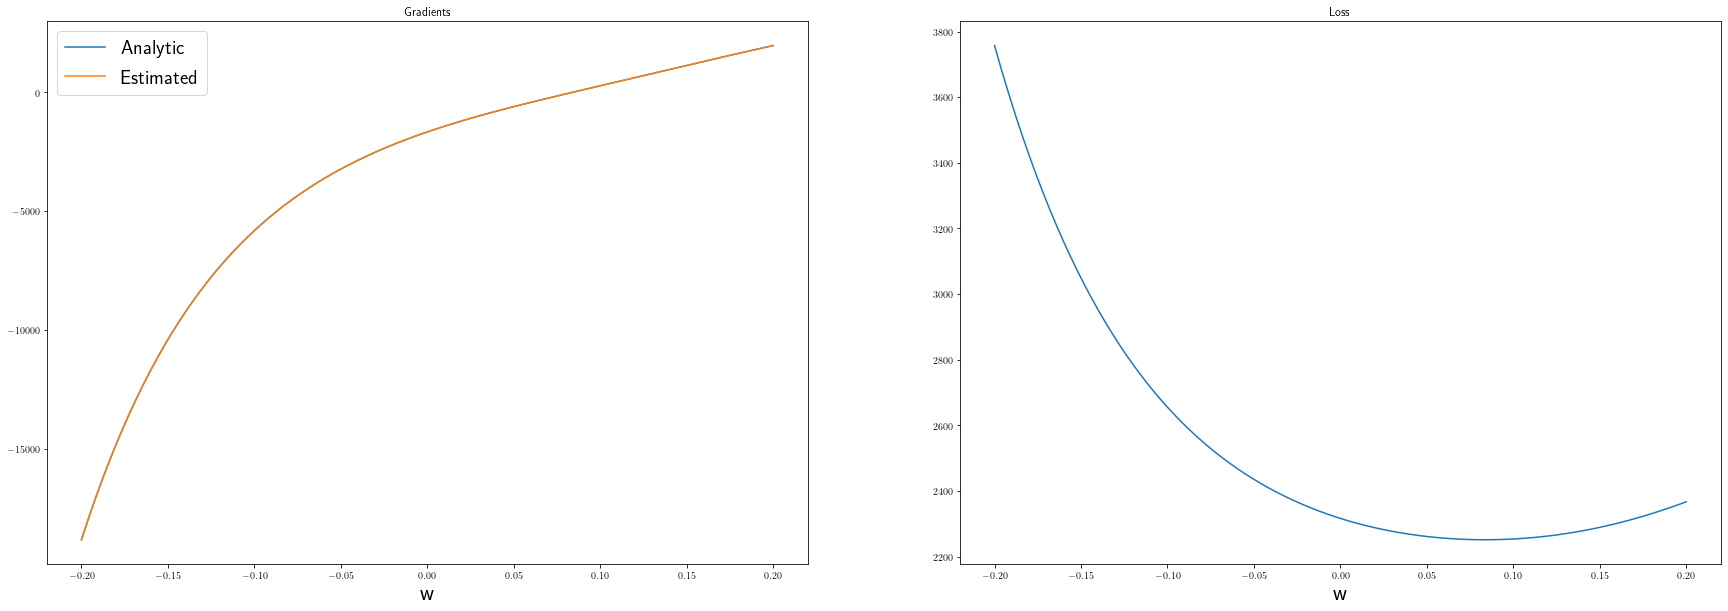

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10))

ax[0].plot(ws, grads, label='Analytic')
ax[0].plot(ws, est_grads, label='Estimated')
ax[0].legend(fontsize=20)
ax[0].set_title('Gradients')
ax[0].set_xlabel('w', fontsize=22)


ax[1].plot(ws, losses)
ax[1].set_title('Loss')
ax[1].set_xlabel('w', fontsize=22)


plt.show()